In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

churn = pd.read_csv('../Data/Cleaned_ML_Unknonw.csv')
churn.drop(['Unnamed: 0'], axis=1, inplace=True)

features = churn[['Total_Trans_Ct', 'Total_Revolving_Bal', 'Total_Relationship_Count',
                   'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Ct_Chng_Q4_Q1', 'Avg_Open_To_Buy', 'Customer_Age']]

Text(0, 0.5, 'PCA 2')

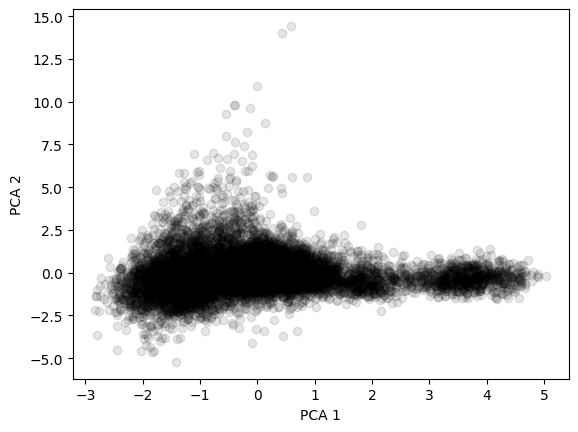

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X = StandardScaler().fit_transform(features)

pca = PCA(n_components=2)
principalComp = pca.fit_transform(X)

PCA_components = pd.DataFrame(principalComp)

plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')




[0.25539003 0.17796825]


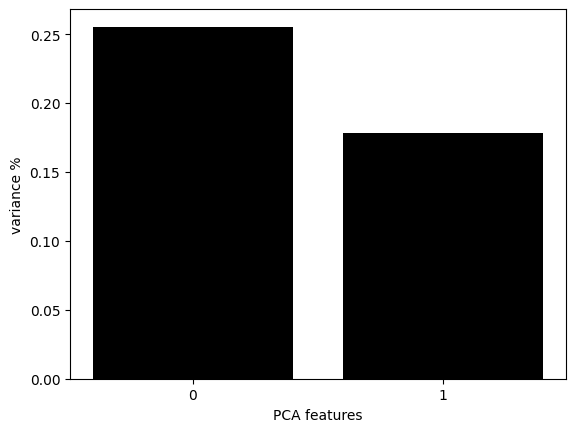

In [3]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print( pca.explained_variance_ratio_)

In [6]:
churn_comp = pd.read_csv('../Data/BankChurners.csv')
churn_comp.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


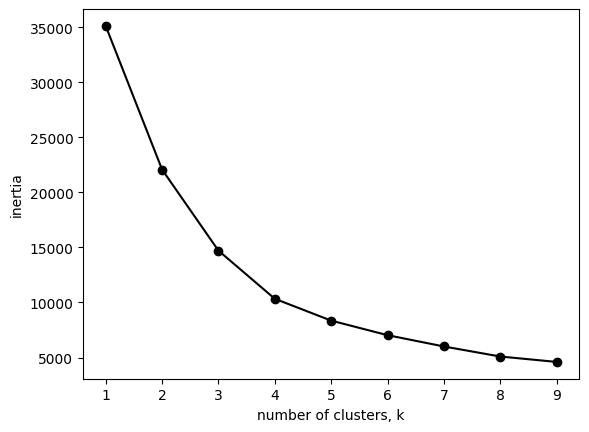

In [4]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,n_init=10)
    
    # Fit model to samples
    model.fit(PCA_components)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

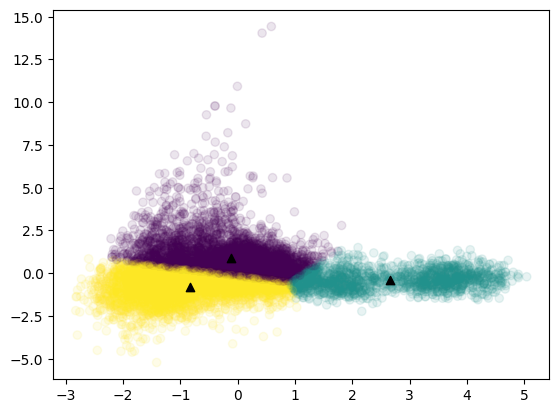

In [7]:
PCA_components.columns = PCA_components.columns.astype(str)
model = KMeans(n_clusters=3,n_init=10,init='k-means++').fit(PCA_components)
cluster_labels = pd.Series(model.labels_, name='cluster')
churn_comp = churn_comp.join(cluster_labels.to_frame())
churn = churn.join(cluster_labels.to_frame())
plt.scatter(PCA_components["0"], PCA_components["1"], alpha=.1, c=cluster_labels)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],
 marker='^', color='black')

churn_comp.to_csv('clusters.csv')

In [151]:
cluster = churn.groupby('cluster')['Attrition_Flag'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
cluster

cluster  Attrition_Flag
0        2                 91.3%
         1                  8.7%
1        2                 94.0%
         1                  6.0%
2        2                 66.2%
         1                 33.8%
Name: Attrition_Flag, dtype: object

In [152]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics


db = DBSCAN(eps=0.8, min_samples=2).fit(PCA_components.iloc[:,:3])
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 0


In [153]:
cluster_db = pd.Series(db.labels_, name='cluster_db')
churn = churn.join(cluster_db.to_frame())
print(churn['cluster_db'].value_counts())

0    10127
Name: cluster_db, dtype: int64


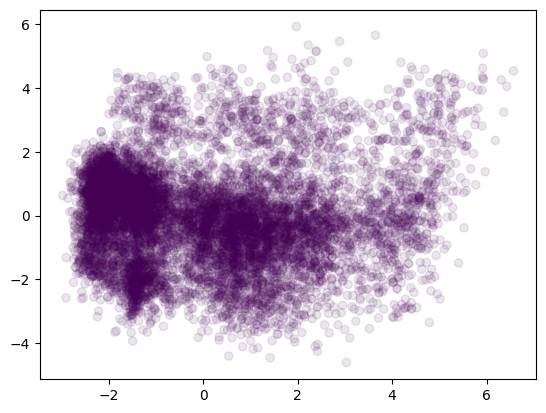

In [154]:
plt.scatter(PCA_components["0"], PCA_components["1"], alpha=.1, c=cluster_db)